## Twitter Emotion Classification

For this project, I trained a CNN on a dataset of approximately 10000 tweets that were labeled as having an emotional valence of happiness or sadness.

I achieved an accuracy and F1 score of approximately 81%.

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import nltk

### Preprocessing

We'll be using GloVe word vectors, so ideally we preprocess the tweets in the same way. And so, we
1. Use GloVe's preprocessing script
2. Tokenize with nltk
3. Vectorize with GloVe

In [211]:
!ls datasets

data_file = 'datasets/text_emotion.csv'
df = pd.read_csv(data_file)

disaster_relevant.csv      emotion_filtered_clean.csv
emotion_filtered.csv       text_emotion.csv


In [212]:
df

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
...,...,...,...,...
39995,1753918954,neutral,showMe_Heaven,@JohnLloydTaylor
39996,1753919001,love,drapeaux,Happy Mothers Day All my love
39997,1753919005,love,JenniRox,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,ipdaman1,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [213]:
df = df.drop(['tweet_id', 'author'], axis=1)
df

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...
...,...,...
39995,neutral,@JohnLloydTaylor
39996,love,Happy Mothers Day All my love
39997,love,Happy Mother's Day to all the mommies out ther...
39998,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [214]:
print(set(df['sentiment']))
print(df['sentiment'].value_counts())

{'fun', 'sadness', 'boredom', 'anger', 'surprise', 'empty', 'hate', 'worry', 'neutral', 'love', 'relief', 'happiness', 'enthusiasm'}
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64


In [215]:
# The classes are pretty unbalanced! 
# Let's predict happiness vs sadness, since they might be the easiest to classify.

selected_rows = df['sentiment'].isin(['happiness', 'sadness'])

df = df.loc[selected_rows]
df = df.reset_index()
df = df.drop(['index'], axis=1)
df

,sentiment,content
0,sadness,Layin n bed with a headache ughhhh...waitin o...
1,sadness,Funeral ceremony...gloomy friday...
2,sadness,"I should be sleep, but im not! thinking about ..."
3,sadness,@charviray Charlene my love. I miss you
4,sadness,@kelcouch I'm sorry at least it's Friday?
...,...,...
10369,happiness,going to watch boy in the striped pj's hope i ...
10370,happiness,"gave the bikes a thorough wash, degrease it an..."
10371,happiness,"had SUCH and AMAZING time last night, McFly we..."
10372,happiness,Succesfully following Tayla!!


In [216]:
# Add class_label column
df['class_label'] = pd.Series([int(x) for x in df['sentiment'] == 'happiness'])
df

,sentiment,content,class_label
0,sadness,Layin n bed with a headache ughhhh...waitin o...,0
1,sadness,Funeral ceremony...gloomy friday...,0
2,sadness,"I should be sleep, but im not! thinking about ...",0
3,sadness,@charviray Charlene my love. I miss you,0
4,sadness,@kelcouch I'm sorry at least it's Friday?,0
...,...,...,...
10369,happiness,going to watch boy in the striped pj's hope i ...,1
10370,happiness,"gave the bikes a thorough wash, degrease it an...",1
10371,happiness,"had SUCH and AMAZING time last night, McFly we...",1
10372,happiness,Succesfully following Tayla!!,1


In [217]:
# preprocessing ruby script ported to python
# source: https://gist.github.com/tokestermw/cb87a97113da12acb388

import sys
import re

FLAGS = re.MULTILINE | re.DOTALL

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = "<hashtag> {} <allcaps>".format(hashtag_body)
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"


def preprocess(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\S+", hashtag)
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    text = re_sub(r"([A-Z]){2,}", allcaps)

    return text.lower()

df['content'] = df['content'].apply(preprocess)
df

,sentiment,content,class_label
0,sadness,layin n bed with a headache ugh <elong>. <rep...,0
1,sadness,funeral ceremony. <repeat>gloomy friday. <repeat>,0
2,sadness,"i should be sleep, but im not! thinking about ...",0
3,sadness,<user> charlene my love. i miss you,0
4,sadness,<user> i'm sorry at least it's friday?,0
...,...,...,...
10369,happiness,going to watch boy in the striped pj's hope i ...,1
10370,happiness,"gave the bikes a thorough wash, degrease it an...",1
10371,happiness,had such <allcaps> and amazing <allcaps> time ...,1
10372,happiness,succesfully following tayla! <repeat>,1


In [218]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\<\w+\>|\w+|[,;.!?]')

df['content'] = df['content'].apply(tokenizer.tokenize)
df

,sentiment,content,class_label
0,sadness,"[layin, n, bed, with, a, headache, ugh, <elong...",0
1,sadness,"[funeral, ceremony, ., <repeat>, gloomy, frida...",0
2,sadness,"[i, should, be, sleep, ,, but, im, not, !, thi...",0
3,sadness,"[<user>, charlene, my, love, ., i, miss, you]",0
4,sadness,"[<user>, i, m, sorry, at, least, it, s, friday...",0
...,...,...,...
10369,happiness,"[going, to, watch, boy, in, the, striped, pj, ...",1
10370,happiness,"[gave, the, bikes, a, thorough, wash, ,, degre...",1
10371,happiness,"[had, such, <allcaps>, and, amazing, <allcaps>...",1
10372,happiness,"[succesfully, following, tayla, !, <repeat>]",1


In [220]:
# Load word vectors
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

folder = 'glove.twitter.27B'
glove_path = f"{folder}/glove.twitter.27B.200d.txt"
glove_w2v_path = f"{folder}/glove.w2vformat.txt"

glove2word2vec(glove_path, glove_w2v_path)

vectors = KeyedVectors.load_word2vec_format(glove_w2v_path, binary=False)

pickle.dump(vectors, 'glove_vectors')

In [221]:
def vectorize(tweet, vectors):
    return [vectors[word] if word in vectors else np.zeros(200) for word in tweet]

df['content'] = df['content'].apply(lambda tweet: vectorize(tweet, vectors))

In [222]:
# Cut the tweet matrices to a fixed size

def truncate(matrix, length):
    mat = np.array(matrix)
    
    if mat.shape[0] > length:
        mat = np.split(mat, [length], axis=0)[0]
    else:
        resized = np.zeros((length, mat.shape[1]))
        resized[:mat.shape[0], :] = mat
        mat = resized

    return mat


def tensorize(matrix):
    """ Add channel dimension """
    
    return np.expand_dims(matrix, axis=0)

df['content'] = df['content'].apply(lambda mat: tensorize(truncate(mat, 80)))

In [223]:
from torch.utils.data import Dataset, DataLoader, random_split

class DataFrameDataset(Dataset):
    def __init__(self, df):
        self.df = df.to_dict(orient='records')

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        return self.df[idx]
    
torch.manual_seed(0)
# data_loader = DataLoader(DataFrameDataset(df), shuffle=True)  

def split(dataset, train_ratio, test_ratio):
    length = len(dataset)
    return random_split(dataset, [int(train_ratio*length), 
                                  int(test_ratio*length), 
                                  length - int(train_ratio*length) - int(test_ratio*length)])


train_set, valid_set, test_set = split(DataFrameDataset(df), 0.7, 0.1)

train_loader = DataLoader(train_set, shuffle=True)
valid_loader = DataLoader(valid_set, shuffle=True)
test_loader = DataLoader(test_set, shuffle=True)
    

In [224]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5,200), stride=(1,200), padding=(2, 0))
        self.pool1 = nn.MaxPool2d((2, 1))
        self.conv2 = nn.Conv2d(6, 12, (5, 1), padding=(2,0))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(240, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = x.float()
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool1(F.relu(self.conv2(x)))
        x = x.view(1, -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
        

model = Net()

torch.manual_seed(0)
sample = next(iter(train_loader))
model(sample['content'])

tensor([[ 0.1298, -0.0596]], grad_fn=<AddmmBackward>)

In [225]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.6)

In [198]:
# number of epochs to train the model
n_epochs = 8

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # train 
    model.train()
    for sample in train_loader:
        target, data = sample['class_label'], sample['content']

        optimizer.zero_grad()
        
        output = model(data)
#         calculate the batch loss

        loss = criterion(output, target)

        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
    
    # validate
    model.eval()
    for sample in valid_loader:
        target, data = sample['class_label'], sample['content']

        # forward pass: compute predicted outputs by passing inputs to the model
        
        output = model(data)
    
        loss = criterion(output, target)

        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_emotion_filtered2.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.331528 	Validation Loss: 0.418245
Validation loss decreased (inf --> 0.418245).  Saving model ...
Epoch: 2 	Training Loss: 0.318516 	Validation Loss: 0.446307
Epoch: 3 	Training Loss: 0.304516 	Validation Loss: 0.422455
Epoch: 4 	Training Loss: 0.298474 	Validation Loss: 0.423263
Epoch: 5 	Training Loss: 0.288865 	Validation Loss: 0.429204
Epoch: 6 	Training Loss: 0.281582 	Validation Loss: 0.443423
Epoch: 7 	Training Loss: 0.275020 	Validation Loss: 0.457037
Epoch: 8 	Training Loss: 0.262834 	Validation Loss: 0.454716


0.8106936416184971


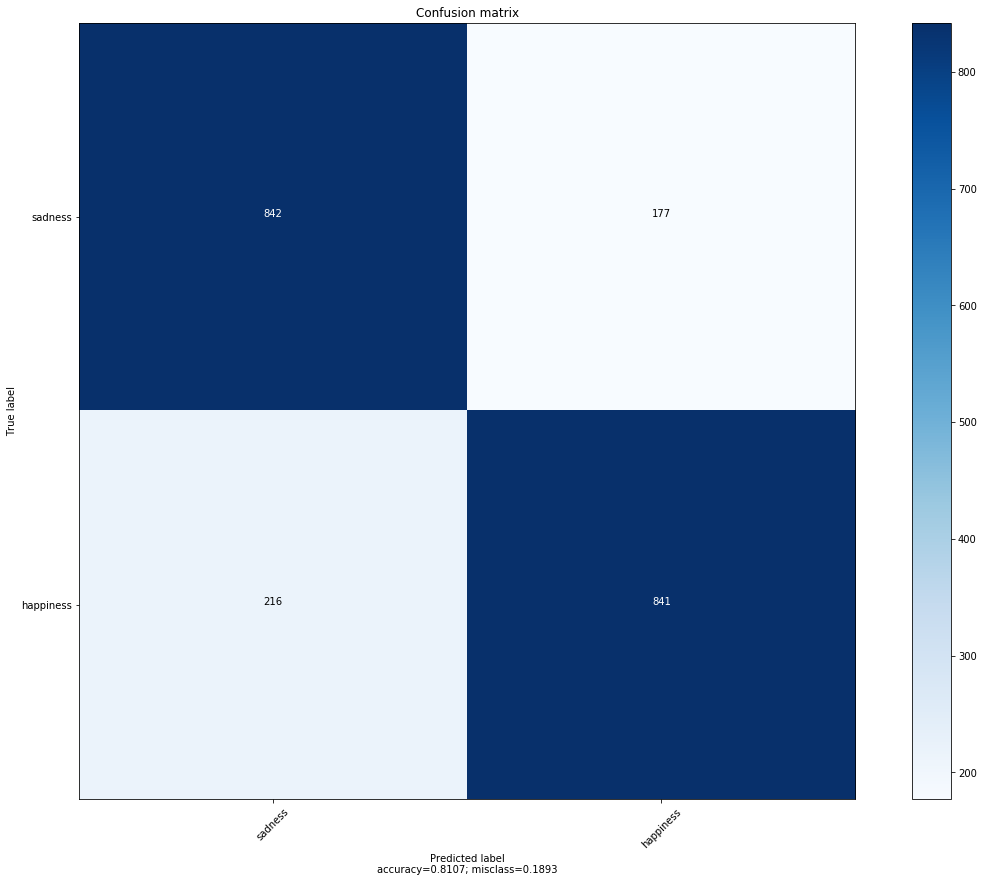

In [230]:
from sklearn.metrics import confusion_matrix
import itertools

accuracy = 0
y_true = []
y_pred = []


# model.load_state_dict(torch.load('model_emotion_filtered.pt'))

accuracy = 0
for sample in test_loader:
    output = model(sample['content'])
    
    ps = torch.exp(output)
    _, y_hat = ps.topk(1)
    y_true.append(sample['class_label'][0])
    y_pred.append(y_hat[0][0])
    
    if y_true[-1] == y_pred[-1]:
        accuracy += 1
    
print(accuracy/len(test_loader))
    
# print(y_true, y_pred)
    
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(16, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(confusion_matrix(y_true, y_pred), ['sadness', 'happiness'])